In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Path to the file
file_name = 'c101'

file_path = f'Solomon_25/{file_name}.txt'

# Read the file
with open(file_path, 'r') as f:
    lines = f.readlines()

# Find the line index where the CUSTOMER data begins
for i, line in enumerate(lines):
    if line.strip().startswith("CUST NO."):
        header_index = i
        break

# Extract header and data
header_line = lines[header_index].split()
data_lines = lines[header_index + 2:]  # Skip the empty line after the header

# Parse the data
data = []
for line in data_lines:
    if line.strip():  # Skip empty lines
        parts = line.split()
        data.append([int(part) for part in parts])

print(np.shape(data))

(101, 7)


In [3]:
print(header_line)

['CUST', 'NO.', 'XCOORD.', 'YCOORD.', 'DEMAND', 'READY', 'TIME', 'DUE', 'DATE', 'SERVICE', 'TIME']


In [4]:
# Create a DataFrame
df = pd.DataFrame(data, columns=['Index', 'X', 'Y', 'Demand', 'Start', 'End', 'Duration'])
df.set_index('Index', inplace=True)

In [6]:
df = df[['X', 'Y']]

In [7]:
df.head()

,X,Y
Index,,
0,40,50
1,45,68
2,45,70
3,42,66
4,42,68


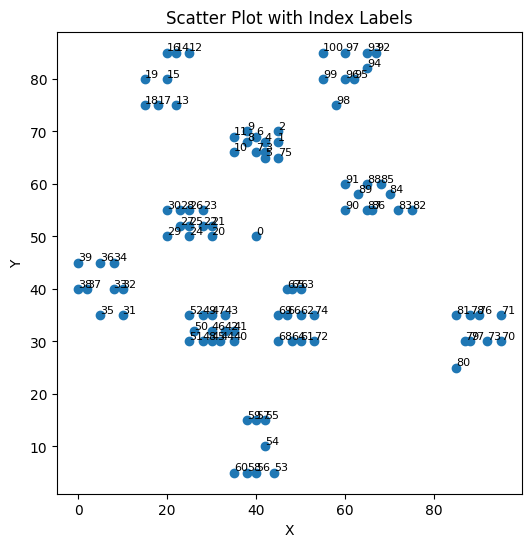

In [8]:
plt.figure(figsize=(6, 6))

# Scatter plot
plt.scatter(df['X'], df['Y'])

# Annotate each point with its index
for idx, row in df.iterrows():
    plt.text(row['X'], row['Y'], str(idx), fontsize=8, ha='left', va='bottom')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot with Index Labels')

plt.show()

We need to randomly assign event numbers to each coordinate. Then, we will turn this into a data set suitable for our ``data_loader``.

In [9]:
# add a column for Type
# set Type of the first row as '0'
# for the rest, randomly sample numbers from 1 to 100 and assign them to Type.
# set seed for reproducibility
np.random.seed(42)
df['Event'] = 0
df.loc[1:, 'Event'] = np.random.choice(np.arange(1, 101), size=len(df) - 1, replace=False)
# Display the DataFrame
df.head()

,X,Y,Event
Index,,,
0,40,50,0
1,45,68,84
2,45,70,54
3,42,66,71
4,42,68,46


In [11]:
# save this dataframe to a csv file
output_file = f'solomon_25_{file_name}_event_index.csv'
df.to_csv(output_file, index_label='Index')

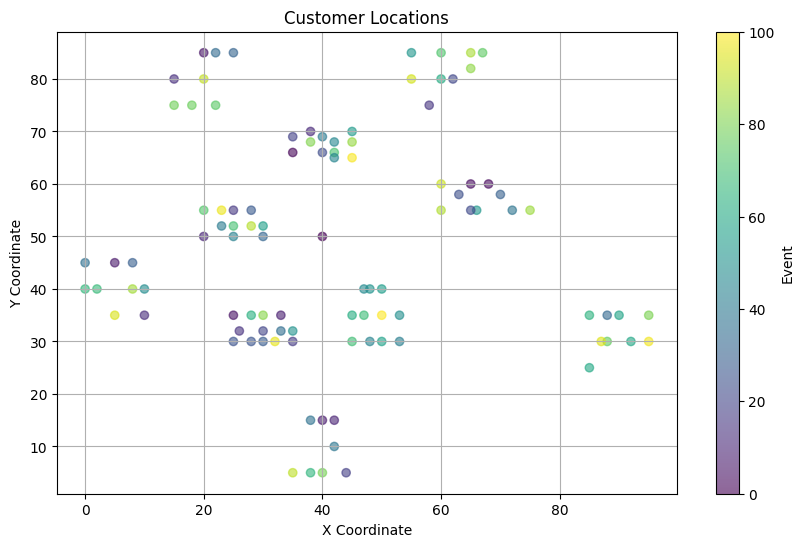

In [10]:
# plot the X and Y coordinates
plt.figure(figsize=(10, 6))
plt.scatter(df['X'], df['Y'], c=df['Event'], cmap='viridis', alpha=0.6)
plt.colorbar(label='Event')
plt.title('Customer Locations')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid()
plt.show()

We will first create the ``C_travel`` matrix. Recall
```# C_travel has shape (m + n) x (m + 1)
        C_event = C_travel[:m, :m] # m x m matrix
        C_home = C_travel[m:, :m].T # m x n matrix
        C_depot = C_travel[:, -1] # (m+n) x 1 vector

In [12]:
# for those with type value between 1 and 50 (inclusive), create a matrix by fill in the Eucliden distance calculated by X and Y coordinates
def euclidean_distance(row1, row2):
    return np.sqrt((row1['X'] - row2['X']) ** 2 + (row1['Y'] - row2['Y']) ** 2)

In [13]:
# create a distance matrix
C_event = pd.DataFrame(index=df.index, columns=df.index)
for i in df.index:
    for j in df.index:
        if df.loc[i, 'Event'] <= 50 and df.loc[j, 'Event'] <= 50 and df.loc[i, 'Event'] != 0 and df.loc[j, 'Event'] != 0:
            C_event.loc[i, j] = euclidean_distance(df.loc[i], df.loc[j])
        else:
            C_event.loc[i, j] = np.nan  # Fill with NaN for other types
# drop rows and columns with all NaN values
C_event.dropna(how='all', inplace=True)
C_event.dropna(axis=1, how='all', inplace=True)

In [14]:
C_event = C_event.astype(int)
C_event.head()

Index,4,5,6,7,9,10,11,12,14,16,...,74,78,83,84,85,87,88,89,95,98
Index,,,,,,,,,,,,,,,,,,,,,
4,0,3,2,2,4,7,7,24,26,27,...,34,56,32,29,27,26,24,23,23,17
5,3,0,4,2,6,7,8,26,28,29,...,31,54,31,28,26,25,23,22,25,18
6,2,4,0,3,2,5,5,21,24,25,...,36,58,34,31,29,28,26,25,24,18
7,2,2,3,0,4,5,5,24,26,27,...,33,57,33,31,28,27,25,24,26,20
9,4,6,2,4,0,5,3,19,21,23,...,38,61,37,34,31,30,28,27,26,20


Next, consider travel between home and events. 

In [17]:
C_home = pd.DataFrame(index=df.index, columns=df.index)
for i in df.index:
    for j in df.index:
        # i is from home type (>50), j is from event type (<=50) but not depot
        if df.loc[i, 'Event'] > 50 and df.loc[j, 'Event'] <= 50 and df.loc[j, 'Event'] != 0:
            C_home.loc[i, j] = euclidean_distance(df.loc[i], df.loc[j])
        else:
            C_home.loc[i, j] = np.nan  # Fill with NaN for other types

C_home.dropna(how='all', inplace=True)
C_home.dropna(axis=1, how='all', inplace=True)

C_home = C_home.astype(int)
print(np.shape(C_home))
C_home.head()

(50, 50)


Index,4,5,6,7,9,10,11,12,14,16,...,74,78,83,84,85,87,88,89,95,98
Index,,,,,,,,,,,,,,,,,,,,,
1,3,4,5,5,7,10,10,26,28,30,...,33,54,29,26,24,23,21,20,20,14
2,3,5,5,6,7,10,10,25,27,29,...,35,55,30,27,25,25,22,21,19,13
3,2,1,3,2,5,7,7,25,27,29,...,32,55,31,29,26,25,23,22,24,18
8,4,5,2,2,2,3,3,21,23,24,...,36,59,36,33,31,29,28,26,26,21
13,21,22,18,20,16,15,14,10,10,10,...,50,77,53,50,48,47,45,44,40,36


Finally, get ``C_depot_e`` (m by 1) and ``C_depot_h`` (n by 1)

In [21]:
C_depot_e = pd.DataFrame(index=df.index, columns=df.index)

for i in C_event.index:
    if i != 0:
        C_depot_e.loc[i, 0] = euclidean_distance(df.loc[i], df.loc[0])
C_depot_e.dropna(how='all', inplace=True)
C_depot_e.dropna(axis=1, how='all', inplace=True)

C_depot_e = C_depot_e.astype(int)
C_depot_e.head()

Index,0
Index,
4,18
5,15
6,19
7,16
9,20


In [22]:
C_depot_h = pd.DataFrame(index=df.index, columns=df.index)

for i in C_home.index:
    if i != 0:
        C_depot_h.loc[i, 0] = euclidean_distance(df.loc[i], df.loc[0])
C_depot_h.dropna(how='all', inplace=True)
C_depot_h.dropna(axis=1, how='all', inplace=True)

C_depot_h = C_depot_h.astype(int)
C_depot_h.head()

Index,0
Index,
1,18
2,20
3,16
8,18
13,30


Create C_dur for the duration of each event. 

In [50]:
# get rows from df where index is in C_event.index
event_index = df.loc[C_event.index].copy()
event_index.drop(columns=['X', 'Y', 'Event'], inplace=True)
event_index.head()

""
Index
4
5
6
7
9


In [34]:
# read from real-nurse-dur.xlsx
real_data = pd.read_excel('real-nurse-dur.xlsx', index_col=0)
# randomly sample 50 rows from real_data without replacement
sampled_data = real_data.sample(n=50, replace=False, random_state=42)
print(len(sampled_data))
sampled_data.head()

50


,RN,LVN,Duration
Event,,,
1,2,2,300
6,3,7,300
47,1,2,120
32,1,2,180
14,2,1,150


In [35]:
# merge sampled_data['Duration'] with C_dur
C_dur = event_index.copy()
C_dur['Duration'] = sampled_data['Duration'].values
C_dur.head()

,Duration
Index,
4,300
5,300
6,120
7,180
9,150


In [48]:
# merge sampled_data[['RN', 'LVN']] with event_index
min_nurse = event_index.copy()
min_nurse['RN'] = sampled_data['RN'].values
min_nurse['LVN'] = sampled_data['LVN'].values
min_nurse.head()

,RN,LVN
Index,,
4,2,2
5,3,7
6,1,2
7,1,2
9,2,1


Set up time windows. 

In [ ]:
# read from five_time_windows.xlsx
# there are five sheets
type = 'Even'
time_windows_raw = pd.read_excel('five_time_windows.xlsx', sheet_name=type,index_col=0)
# replace index of time_windows_raw with event_index
time_windows = event_index.copy()
time_windows[['Start_1', 'End_1', 'Start_2', 'End_2', 'Start_3', 'End_3', 'Start_4', 'End_4', 'Start_5', 'End_5']] = time_windows_raw[['Start_1', 'End_1', 'Start_2', 'End_2', 'Start_3', 'End_3', 'Start_4', 'End_4', 'Start_5', 'End_5']].values
time_windows.head()

,Start_1,End_1,Start_2,End_2,Start_3,End_3,Start_4,End_4,Start_5,End_5
Index,,,,,,,,,,
4,570,810,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,570,810
6,0,0,0,0,0,0,0,0,570,810
7,0,0,570,810,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,570,810


Create a dataframe to store parameters.
```
Parameter	Value
nr	20
nl	30
m	50
day	5

In [37]:
Setting = pd.DataFrame({'Parameter': ['nr', 'nl', 'm', 'day'], 
                       'Value': [20, 30, 50, 5]})
Setting

,Parameter,Value
0,nr,20
1,nl,30
2,m,50
3,day,5


Save everything to a multi-sheet xslx file.

In [ ]:
# save data frames to separate sheets of xlsx file
with pd.ExcelWriter(f'{file_name}_data.xlsx') as writer:
    Setting.to_excel(writer, sheet_name='Settings', index=False)
    C_event.to_excel(writer, sheet_name='C_event')
    C_home.to_excel(writer, sheet_name='C_home')
    C_depot_e.to_excel(writer, sheet_name='C_depot_e')
    C_depot_h.to_excel(writer, sheet_name='C_depot_h')
    C_dur.to_excel(writer, sheet_name='C_dur')
    time_windows.to_excel(writer, sheet_name='Time_Windows')
    min_nurse.to_excel(writer, sheet_name='Min_Nurses')
    